<a href="https://colab.research.google.com/github/BennoKrojer/ML2/blob/main/Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP 551 - Mini Project 2


In [ ]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%%capture
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/diabetes_data/diabetes_train.csv
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/diabetes_data/diabetes_test.csv
!wget https://raw.githubusercontent.com/BennoKrojer/ML2/main/diabetes_data/diabetes_val.csv

In [ ]:
train = genfromtxt('diabetes_train.csv', delimiter=',', skip_header=1)
test = genfromtxt('diabetes_test.csv', delimiter=',', skip_header=1)
val = genfromtxt('diabetes_val.csv', delimiter=',', skip_header=1)
train_x, train_y = train[:,:-1], train[:,-1]
test_x, test_y = test[:,:-1], test[:,-1]
val_x, val_y = val[:,:-1], val[:,-1]
print(train_x.shape)

(600, 8)


## Logistic Regression: Fully Batched

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

In [ ]:
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, eval_steps=100):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.eval_steps = eval_steps

    def fit(self, x, y, val_x, val_y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        steps = []
        train_accs = []
        val_accs = []
        best_val_acc = 0
        best_step = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g
            t += 1
            if t % self.eval_steps == 0:
                yh = self.predict(x)
                yh = yh > 0.5
                preds = y == yh
                train_acc = sum(preds) / len(preds)

                val_yh = self.predict(val_x, add_bias=True)
                val_yh = val_yh > 0.5
                val_preds = val_y == val_yh
                val_acc = sum(val_preds) / len(val_preds)

                steps.append(t)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_step = t

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, steps, train_accs, val_accs, best_val_acc, best_step

    def predict(self, x, add_bias=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))  # predict output
        return yh



LogisticRegression.gradient = gradient             #initialize the gradient method of the LogisticRegression class with gradient function

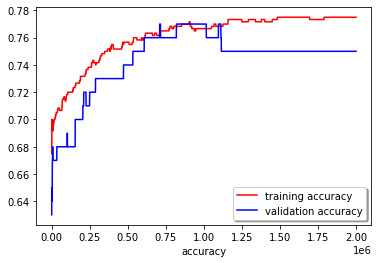

0.0002
0.77
709300


In [ ]:
for lr in [0.0004, 0.0002, 0.0001, 0.00005]:
    logres = LogisticRegression(max_iters=2e6, learning_rate=lr)
    model, steps, train_accs, val_accs, best_val_acc, best_step = logres.fit(train_x, train_y, val_x, val_y)
    plt.plot(steps, train_accs, 'r', label='training accuracy')
    plt.plot(steps, val_accs, 'b', label='validation accuracy')
    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.show()
    print(lr)
    print(best_val_acc)
    print(best_step)

## Mini-Batch Logistic Regression

In [ ]:
class MiniBatchLogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, batch_size=8, max_iters=1e5, verbose=False,
                 eval_steps=100, shuffle=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.eval_steps = eval_steps
        self.batch_size = batch_size
        self.shuffle = shuffle

    def fit(self, x, y, val_x, val_y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        steps = []
        train_accs = []
        val_accs = []
        best_val_acc = 0
        best_step = 0
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            if self.shuffle:
                p = np.random.permutation(int(y.shape[0]))
                x = x[p]
                y = y[p]
            for i in range(0, int(y.shape[0]), self.batch_size):
                batch_x = x[i:i+self.batch_size]
                batch_y = y[i:i+self.batch_size]
                g = self.gradient(batch_x, batch_y)
                self.w = self.w - self.learning_rate * g
            t += 1
            if t % self.eval_steps == 0:
                print(t)
                yh = self.predict(x)
                yh = yh > 0.5
                preds = y == yh
                train_acc = sum(preds) / len(preds)

                val_yh = self.predict(val_x, add_bias=True)
                val_yh = val_yh > 0.5
                val_preds = val_y == val_yh
                val_acc = sum(val_preds) / len(val_preds)

                steps.append(t)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_step = t

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, steps, train_accs, val_accs, best_val_acc, best_step

    def predict(self, x, add_bias=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))  # predict output
        return yh


In [ ]:
MiniBatchLogisticRegression.gradient = gradient  # initialize the gradient method of the LogisticRegression class with gradient function

taccs = {}
vaccs = {}
for size in [8, 16, 32, 64, 600]:
    logres = MiniBatchLogisticRegression(max_iters=1e6, learning_rate=0.0002, batch_size=size)
    model, steps, train_accs, val_accs, best_val_acc, best_step = logres.fit(train_x, train_y, val_x, val_y)
    taccs[size] = train_accs
    vaccs[size] = val_accs

plt.xlabel('iterations')
plt.ylabel('accuracy')
for size, vals in taccs.items():
    plt.plot(steps, vals, label=f'batch size {size}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.show()

plt.xlabel('iterations')
plt.ylabel('accuracy')
for size, vals in vaccs.items():
    plt.plot(steps, vals, label=f'batch size {size}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plt.show()


## Momentum Fully Batched Gradient Descent

In [ ]:
def gradient(self, x, y):
    N, D = x.shape
    yh = logistic(np.dot(x, self.w))  # predictions  size N
    grad = np.dot(x.T, yh - y) / N  # divide by N because cost is mean over N points
    J = np.mean(-y * np.log(yh) - (1-y) * np.log(1-yh))
    return grad, J  # size D

In [ ]:
class LogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, eval_steps=100, momentum_beta=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.eval_steps = eval_steps
        self.momentum_beta = momentum_beta

    def fit(self, x, y, val_x, val_y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        steps = []
        train_accs = []
        val_accs = []
        losses = []
        best_val_acc = 0
        best_step = 0
        prev = np.zeros(D)
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g, loss = self.gradient(x, y)
            g = self.momentum_beta * prev + (1-self.momentum_beta) * g
            prev = g
            self.w = self.w - self.learning_rate * g
            t += 1
            if t % self.eval_steps == 0:
                yh = self.predict(x)
                yh = yh > 0.5
                preds = y == yh
                train_acc = sum(preds) / len(preds)

                val_yh = self.predict(val_x, add_bias=True)
                val_yh = val_yh > 0.5
                val_preds = val_y == val_yh
                val_acc = sum(val_preds) / len(val_preds)

                steps.append(t)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                losses.append(loss)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_step = t

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, steps, train_accs, val_accs, best_val_acc, best_step, losses

    def predict(self, x, add_bias=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))  # predict output
        return yh

In [ ]:
LogisticRegression.gradient = gradient # initialize the gradient method of the LogisticRegression class with gradient function

taccs = {}
vaccs = {}
losses = {}
for beta in [0.8, 0.9, 0.95, 0.99, 0]:
    logres = LogisticRegression(max_iters=2e3, learning_rate=0.0002, momentum_beta=beta)
    model, steps, train_accs, val_accs, best_val_acc, best_step, loss = logres.fit(train_x, train_y, val_x, val_y)
    taccs[beta] = train_accs
    vaccs[beta] = val_accs
    losses[beta] = loss

plt.xlabel('iterations')
plt.ylabel('accuracy')
for beta, vals in taccs.items():
    plt.plot(steps, vals, label=f'momentum coefficient {beta}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plot.show()

plt.xlabel('iterations')
plt.ylabel('accuracy')
for beta, vals in vaccs.items():
    plt.plot(steps, vals, label=f'momentum coefficient {beta}')
    plt.legend(loc='lower right', shadow=True, fontsize='medium')
    plot.show()

plt.xlabel('iterations')
plt.ylabel('cross-entropy loss')
for beta, vals in losses.items():
    plt.plot(steps, vals, label=f'momentum coefficient {beta}')
    plt.legend(loc='upper right', shadow=True, fontsize='medium')
    plt.show()

## Momemtum with Mini-Batch SGD

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

def gradient(self, x, y):
    N,D = x.shape
    yh = logistic(np.dot(x, self.w))    # predictions  size N
    grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
    return grad                         # size D

In [ ]:
class MiniBatchLogisticRegression:

    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, batch_size=8, max_iters=1e5, verbose=False,
                 eval_steps=100, shuffle=False, momentum_beta=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon  # to get the tolerance for the norm of gradients
        self.max_iters = max_iters  # maximum number of iteration of gradient descent
        self.verbose = verbose
        self.eval_steps = eval_steps
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.momentum_beta = momentum_beta

    def fit(self, x, y, val_x, val_y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x, np.ones(N)])
        N, D = x.shape
        self.w = np.zeros(D)
        g = np.inf
        t = 0
        # the code snippet below is for gradient descent
        steps = []
        train_accs = []
        val_accs = []
        best_val_acc = 0
        best_step = 0
        prev = np.zeros(D)
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            if self.shuffle:
                p = np.random.permutation(int(y.shape[0]))
                x = x[p]
                y = y[p]
            if self.batch_size != 600:
                for i in range(0, int(y.shape[0]), self.batch_size):
                    batch_x = x[i:i+self.batch_size]
                    batch_y = y[i:i+self.batch_size]
                    g = self.gradient(batch_x, batch_y)
                    g = self.momentum_beta * prev + (1 - self.momentum_beta) * g
                    self.w = self.w - self.learning_rate * g
                    prev = g
            else:
                g = self.gradient(x, y)
                self.w = self.w - self.learning_rate * g
                prev = g
            t += 1
            if t % self.eval_steps == 0:
                print(t)
                yh = self.predict(x)
                yh = yh > 0.5
                preds = y == yh
                train_acc = sum(preds) / len(preds)

                val_yh = self.predict(val_x, add_bias=True)
                val_yh = val_yh > 0.5
                val_preds = val_y == val_yh
                val_acc = sum(val_preds) / len(val_preds)

                steps.append(t)
                train_accs.append(train_acc)
                val_accs.append(val_acc)
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_step = t

        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self, steps, train_accs, val_accs, best_val_acc, best_step

    def predict(self, x, add_bias=False):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if add_bias:
            x = np.column_stack([x, np.ones(Nt)])
        yh = logistic(np.dot(x, self.w))  # predict output
        return yh

In [ ]:
MiniBatchLogisticRegression.gradient = gradient  # initialize the gradient method of the LogisticRegression class with gradient function

for bs in [8, 64]:
    taccs = {}
    vaccs = {}
    for beta in [0.8, 0.9, 0.95, 0.99, 0]:
        logres = MiniBatchLogisticRegression(max_iters=1e6, learning_rate=0.0002, momentum_beta=beta, batch_size=bs)
        model, steps, train_accs, val_accs, best_val_acc, best_step = logres.fit(train_x, train_y, val_x, val_y)
        taccs[beta] = train_accs
        vaccs[beta] = val_accs

    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    for beta, vals in taccs.items():
        plt.plot(steps, vals, label=f'momentum coefficient {beta}')
        plt.legend(loc='lower right', shadow=True, fontsize='medium')
        plt.show()

    plt.xlabel('iterations')
    plt.ylabel('accuracy')
    for beta, vals in vaccs.items():
        plt.plot(steps, vals, label=f'momentum coefficient {beta}')
        plt.legend(loc='lower right', shadow=True, fontsize='medium')
        plt.show()